# Imports

In [1]:
# Add parent directory to path to import gptransform
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir))
sys.path.insert(0, parent_dir)
import gptransform

# Math libraries
import time
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multivariate_normal import  MultivariateNormal

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import Normalize
import string

# Run in float64 to help with numerical stability
# very crucial, remove with caution
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

# Set up the data

Dividing by the average of values greater than r=20.075000000000003


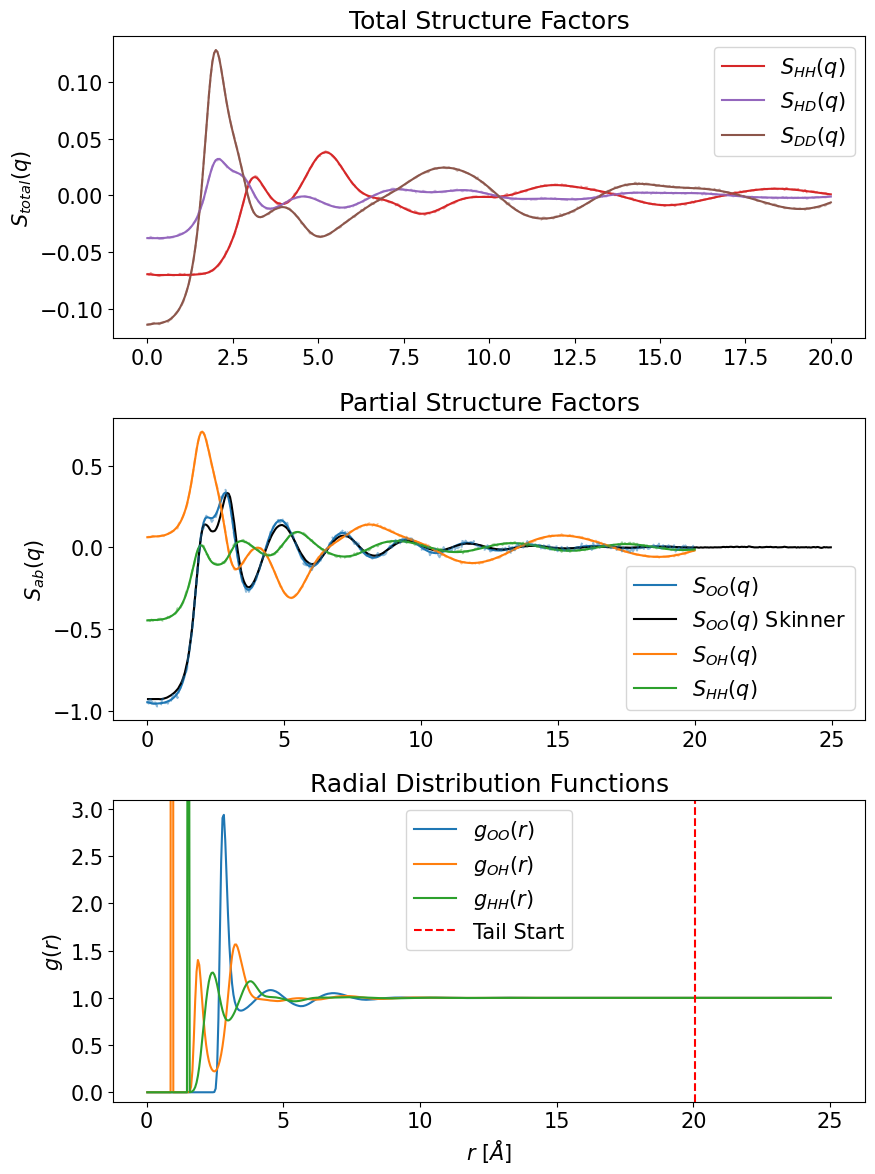

In [2]:
density = 0.0334271795942

# Load the data
file_path = 'water_sim_data_matej/Ambient_water_xray_data.txt'
df = pd.read_csv(file_path, sep='\t', skiprows=12, names=[
    'Q', 'I_X(Q)', 'S_OO(Q)', 'r', 'g_OO(r)', 'error'
])

# Convert to PyTorch tensors
Q = torch.tensor(df['Q'].values, dtype=torch.float32)[1:1001:2]
I_X = torch.tensor(df['I_X(Q)'].values, dtype=torch.float32)[1:1001:2]
S_OO_skinner = torch.tensor(df['S_OO(Q)'].values, dtype=torch.float32)[1:1001:2] - 1
r_skinner = torch.tensor(df['r'].values, dtype=torch.float32)[1:]
g_OO_skinner = torch.tensor(df['g_OO(r)'].values, dtype=torch.float32)[1:]
error_skinner = torch.tensor(df['error'].values, dtype=torch.float32)[1:]

# Scattering lengths for water https://www.ncnr.nist.gov/resources/n-lengths/
σOO = 0.0374
σOH = - 0.0964
σHH = 0.0622

σOHD = 0.0378
σHD = 0.0096

σOD = 0.1721 
σDD = 0.1978

M = torch.tensor([[σOO, σOH , σHH],
                  [σOO, σOHD, σHD],
                  [σOO, σOD , σDD]])

M_inv = torch.linalg.inv(M)

# Load in tip4pf data
HH_dat = np.loadtxt("water_sim_data_matej/tip4pf_NPT_HH.dat")
OH_dat = np.loadtxt("water_sim_data_matej/tip4pf_NPT_OH.dat")
OO_dat = np.loadtxt("water_sim_data_matej/tip4pf_NPT_OO.dat")

r_OH,gr_OH = OH_dat.T[0],OH_dat.T[1]
r_OO,gr_OO = OO_dat.T[0],OO_dat.T[1]
r_HH,gr_HH = HH_dat.T[0],HH_dat.T[1]

r_OH = torch.tensor(r_OH)
gr_OH = torch.tensor(gr_OH)
r_HH = torch.tensor(r_HH)
gr_HH = torch.tensor(gr_HH)
r_OO = torch.tensor(r_OO)
gr_OO = torch.tensor(gr_OO)


average_tail_count = 100
print(f'Dividing by the average of values greater than r={r_OH[-average_tail_count]}')
gr_OH =  gr_OH / torch.mean(gr_OH[-average_tail_count:])
gr_OO =  gr_OO / torch.mean(gr_OO[-average_tail_count:])
gr_HH =  gr_HH / torch.mean(gr_HH[-average_tail_count:])


# Store as matrix for easy dot product application to obtain total G(r)
structure_partial = torch.zeros((3,len(gr_OO)))
structure_partial[0] = gr_OO - 1
structure_partial[1] = gr_OH - 1
structure_partial[2] = gr_HH - 1
structure_total = (M @ structure_partial)


# Establish a q space grid and compute total S(q) structure factors
q = torch.linspace(0.001, 20, 400)
sq_HH = gptransform.rdf2sq(r_OO, structure_total[0], q, density)
sq_HD = gptransform.rdf2sq(r_OO, structure_total[1], q, density)
sq_DD = gptransform.rdf2sq(r_OO, structure_total[2], q, density)

# Get noisless partial S(q)
partial_sq_OO = gptransform.rdf2sq(r_OO, gr_OO-1, q, density)
partial_sq_OH = gptransform.rdf2sq(r_OH, gr_OH-1, q, density)
partial_sq_HH = gptransform.rdf2sq(r_HH, gr_HH-1, q, density)

# Sample some random noise to simulate experimental error
noise_HH = torch.normal(torch.zeros_like(q), torch.ones_like(q)*0.0005)
noise_HD = torch.normal(torch.zeros_like(q), torch.ones_like(q)*0.0005)
noise_DD = torch.normal(torch.zeros_like(q), torch.ones_like(q)*0.0005)

r = r_OO
r_grid = torch.linspace(0.01, 25  , 1000).reshape(-1,1)

# Convert all these things to column vectors for consistency
q_values = q.reshape(-1,1)
sq_HH = sq_HH.reshape(-1,1)
sq_HD = sq_HD.reshape(-1,1)
sq_DD = sq_DD.reshape(-1,1)

partial_sq_OO = partial_sq_OO.reshape(-1,1)
partial_sq_OH = partial_sq_OH.reshape(-1,1)
partial_sq_HH = partial_sq_HH.reshape(-1,1)

noise_HH = noise_HH.reshape(-1,1)
noise_HD = noise_HD.reshape(-1,1)
noise_DD = noise_DD.reshape(-1,1)

# We observe the total structure in experimental data, therefore the noise should be added here.
# Constant noise on the total as a function of deuteration doesnt imply constant over partials
# This is why some partials will be harder to learn, we reflect that here in the toy problem.
sq_noisey_HH = (sq_HH+noise_HH)
sq_noisey_HD = (sq_HD+noise_HD)
sq_noisey_DD = (sq_DD+noise_DD)

# Save total noisey and compute partials via matrix inverse
structure_total_q_noisey = torch.zeros((3,len(q)))
structure_total_q_noisey[0] = sq_noisey_HH.T[0]
structure_total_q_noisey[1] = sq_noisey_HD.T[0]
structure_total_q_noisey[2] = sq_noisey_DD.T[0]
structure_partial_q_noisey = M_inv @ structure_total_q_noisey

# Sometimes I will want to refer to them without the matrix
partial_sq_noisey_OO = structure_partial_q_noisey[0].reshape(-1,1)
partial_sq_noisey_OH = structure_partial_q_noisey[1].reshape(-1,1)
partial_sq_noisey_HH = structure_partial_q_noisey[2].reshape(-1,1)
    
# This allows you to mix up the data so its not ordered by q
perm = torch.randperm(len(structure_total_q_noisey[0]))

# Put into Pytorch Dataloader
# Change the reshape command to get different batch sizes, not needed here as there is not enough observations
# so we can do full gradient descent on the LMLH. 
dataset_OO = gptransform.data(q_values[perm].reshape(1,400,1),structure_partial_q_noisey[0][perm].reshape(1,400,1))
dataset_OH = gptransform.data(q_values[perm].reshape(1,400,1),structure_partial_q_noisey[1][perm].reshape(1,400,1))
dataset_HH = gptransform.data(q_values[perm].reshape(1,400,1),structure_partial_q_noisey[2][perm].reshape(1,400,1))
fig, axs = plt.subplots(3, 1, figsize=(9, 12), sharex=False)

# Plot all the functions for visualization
color_OO = 'tab:blue'
color_OH = 'tab:orange'
color_HH = 'tab:green'
color_HH_tot = 'tab:red'
color_HD_tot = 'tab:purple'
color_DD_tot = 'tab:brown'

axs[0].plot(q_values, sq_HH, label="$S_{HH}(q)$", color=color_HH_tot)
axs[0].plot(q_values, sq_HD, label="$S_{HD}(q)$", color=color_HD_tot)
axs[0].plot(q_values, sq_DD, label="$S_{DD}(q)$", color=color_DD_tot)
axs[0].plot(q_values, sq_noisey_HH, linestyle='dashed', alpha=0.5, color=color_HH_tot)
axs[0].plot(q_values, sq_noisey_HD, linestyle='dashed', alpha=0.5, color=color_HD_tot)
axs[0].plot(q_values, sq_noisey_DD, linestyle='dashed', alpha=0.5, color=color_DD_tot)
axs[0].set_ylabel("$S_{total}(q)$")
axs[0].set_title("Total Structure Factors")
axs[0].legend()

axs[1].plot(q_values, partial_sq_OO, label="$S_{OO}(q)$", color=color_OO)
axs[1].plot(Q, S_OO_skinner, label="$S_{OO}(q)$ Skinner", color='k')
axs[1].plot(q_values, partial_sq_OH, label="$S_{OH}(q)$", color=color_OH)
axs[1].plot(q_values, partial_sq_HH, label="$S_{HH}(q)$", color=color_HH)
axs[1].plot(q_values, partial_sq_noisey_OO, linestyle='dashed', alpha=0.5, color=color_OO)
axs[1].plot(q_values, partial_sq_noisey_OH, linestyle='dashed', alpha=0.5, color=color_OH)
axs[1].plot(q_values, partial_sq_noisey_HH, linestyle='dashed', alpha=0.5, color=color_HH)
axs[1].set_ylabel("$S_{ab}(q)$")
axs[1].set_title("Partial Structure Factors")
axs[1].legend()

axs[2].plot(r_OO, gr_OO, label="$g_{OO}(r)$", color=color_OO)
axs[2].plot(r_OH, gr_OH, label="$g_{OH}(r)$", color=color_OH)
axs[2].plot(r_HH, gr_HH, label="$g_{HH}(r)$", color=color_HH)
axs[2].axvline(r_OH[-average_tail_count], linestyle='dashed', color='r', label='Tail Start')
axs[2].set_ylim(-0.1, 3.1)
axs[2].set_xlabel("$r\ [\AA]$")
axs[2].set_ylabel("$g(r)$")
axs[2].set_title("Radial Distribution Functions")
axs[2].legend()

plt.tight_layout()
plt.show()

# Just save these for later
q_infer = q_values
r_infer = r_grid
temp = 298.15

# Run the optimization

Average loss: -438.502306  [    0/  500]
l:       1.207878 
max:     2.129496 
slope:   2.963173 
loc:     2.285616 
decay:   0.564913 
sigma_n: 0.104263 
r_0:     2.012209 
s:       3.056664 
h:   1.001809 
r:   1.513822 
s:   0.056487 
Minutes Taken Since Last Report: 0.092038 



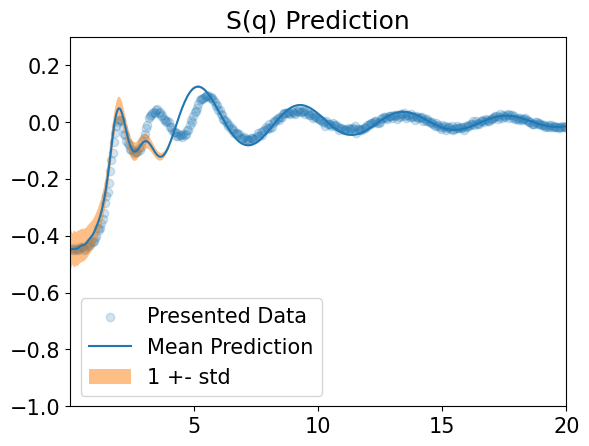

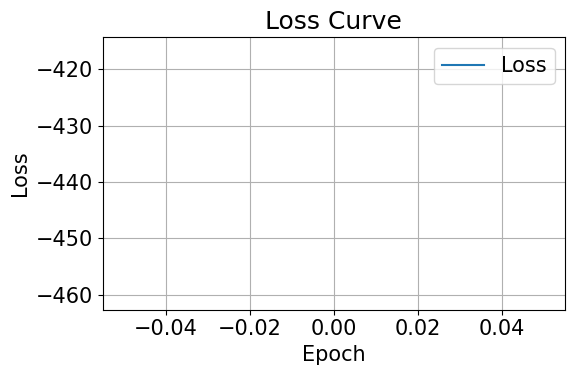

Average loss: -587.734823  [   25/  500]
l:       0.943511 
max:     2.343245 
slope:   2.563909 
loc:     2.056051 
decay:   0.668191 
sigma_n: 0.068974 
r_0:     2.007902 
s:       4.527647 
h:   0.737949 
r:   1.501973 
s:   0.066346 
Minutes Taken Since Last Report: 1.828130 



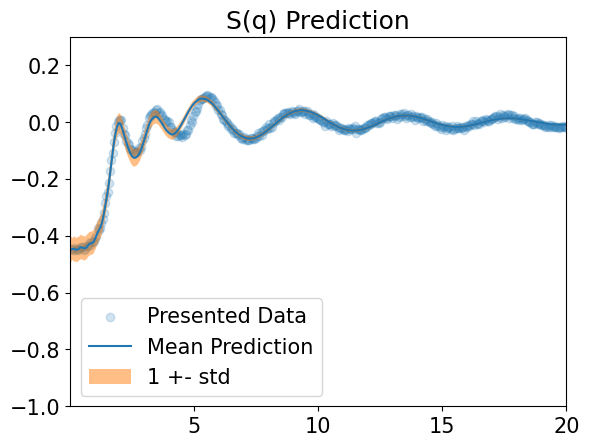

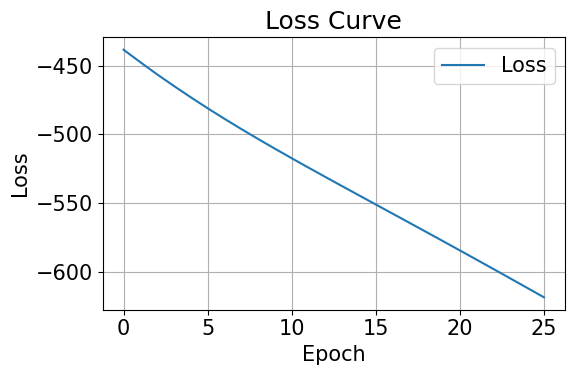

Average loss: -766.252341  [   50/  500]
l:       0.749183 
max:     1.995294 
slope:   2.772378 
loc:     1.997428 
decay:   0.744285 
sigma_n: 0.043810 
r_0:     2.094247 
s:       6.295117 
h:   0.645447 
r:   1.516153 
s:   0.064227 
Minutes Taken Since Last Report: 1.635268 



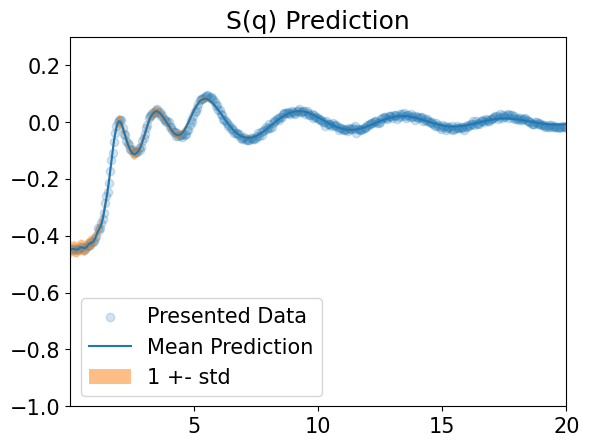

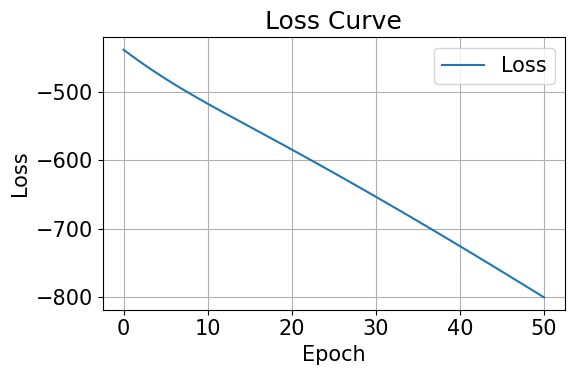

Average loss: -957.072681  [   75/  500]
l:       0.636181 
max:     1.456562 
slope:   3.126009 
loc:     1.975660 
decay:   0.801158 
sigma_n: 0.027066 
r_0:     2.111922 
s:       8.086260 
h:   0.629480 
r:   1.521801 
s:   0.051515 
Minutes Taken Since Last Report: 1.583713 



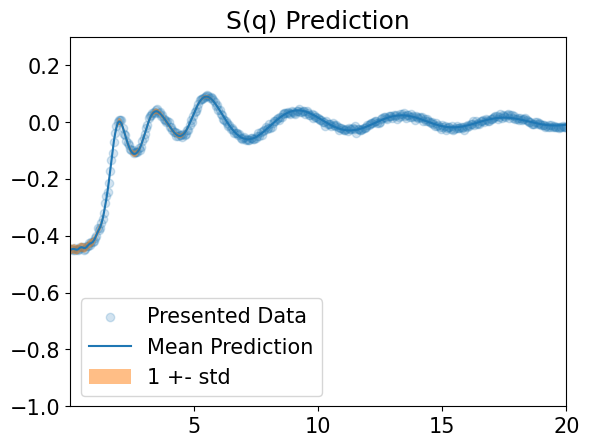

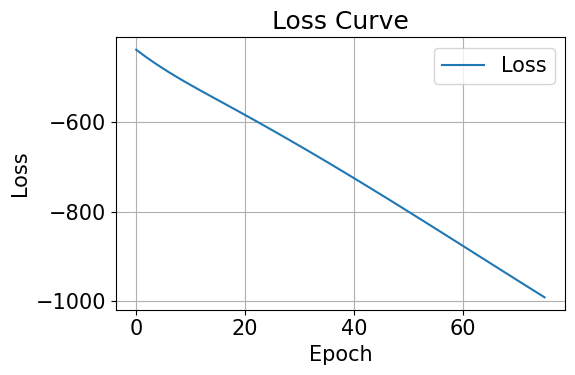

Average loss: -1143.567732  [  100/  500]
l:       0.578643 
max:     1.014759 
slope:   3.535273 
loc:     1.962440 
decay:   0.838067 
sigma_n: 0.016621 
r_0:     2.147457 
s:       9.403188 
h:   0.572652 
r:   1.522846 
s:   0.039235 
Minutes Taken Since Last Report: 1.547926 



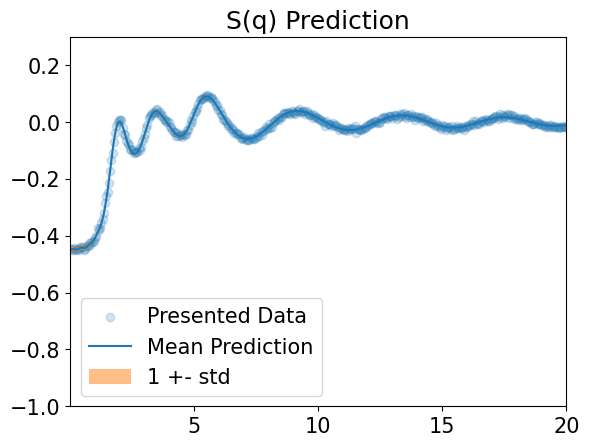

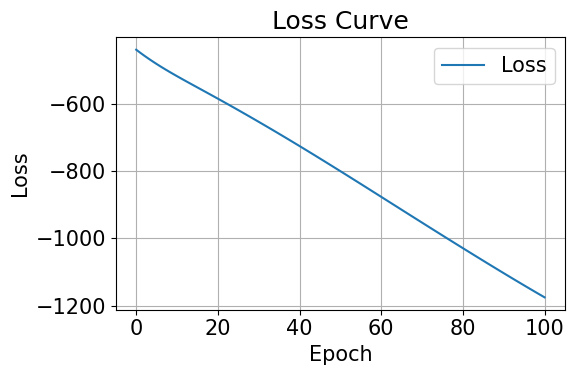

Average loss: -1307.839254  [  125/  500]
l:       0.524914 
max:     0.777436 
slope:   4.093637 
loc:     1.999479 
decay:   0.854173 
sigma_n: 0.010444 
r_0:     2.147410 
s:       10.680768 
h:   0.538514 
r:   1.523308 
s:   0.025797 
Minutes Taken Since Last Report: 1.559597 



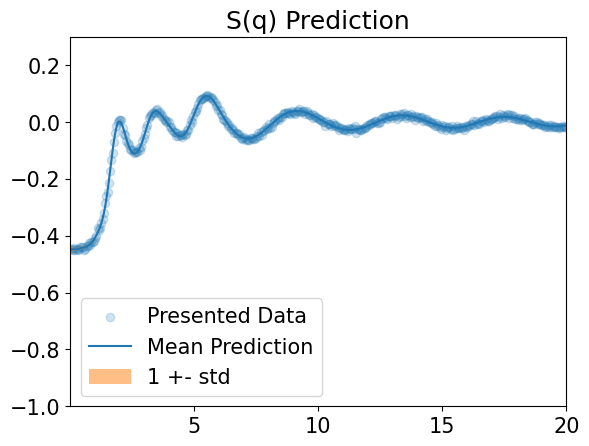

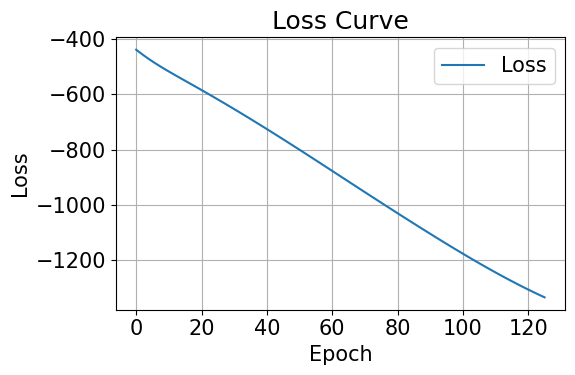

Average loss: -1422.503889  [  150/  500]
l:       0.510635 
max:     0.687296 
slope:   4.856322 
loc:     2.110659 
decay:   0.848968 
sigma_n: 0.007055 
r_0:     2.136769 
s:       11.245619 
h:   0.521897 
r:   1.521906 
s:   0.017404 
Minutes Taken Since Last Report: 1.521478 



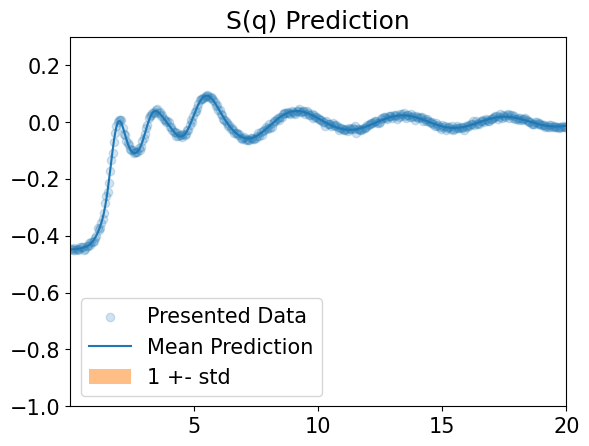

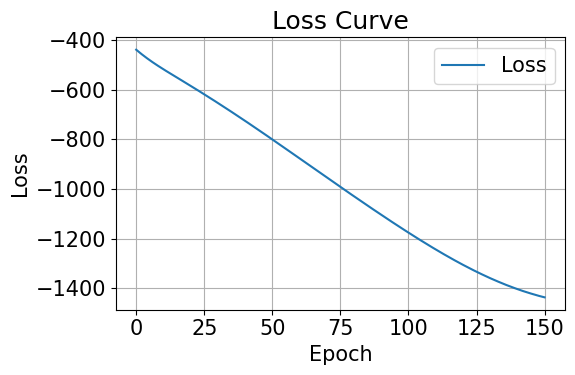

Average loss: -1472.156945  [  175/  500]
l:       0.535469 
max:     0.673786 
slope:   5.689814 
loc:     2.295296 
decay:   0.822574 
sigma_n: 0.005481 
r_0:     2.099686 
s:       10.174470 
h:   0.521397 
r:   1.524248 
s:   0.012810 
Minutes Taken Since Last Report: 1.544693 



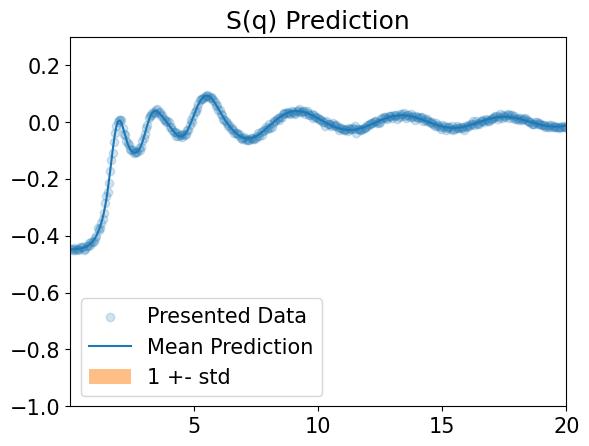

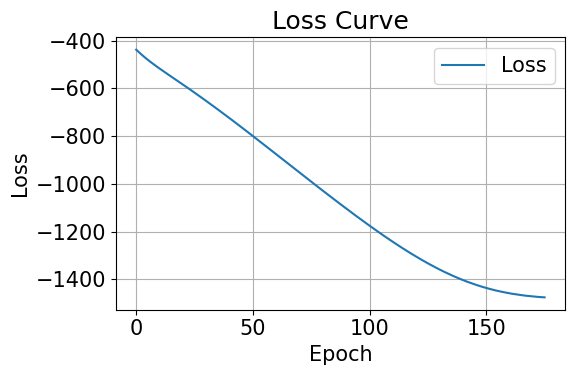

Average loss: -1481.268344  [  200/  500]
l:       0.553931 
max:     0.657251 
slope:   6.690545 
loc:     2.343274 
decay:   0.794804 
sigma_n: 0.004996 
r_0:     2.071795 
s:       10.059470 
h:   0.528057 
r:   1.523362 
s:   0.012084 
Minutes Taken Since Last Report: 1.622190 



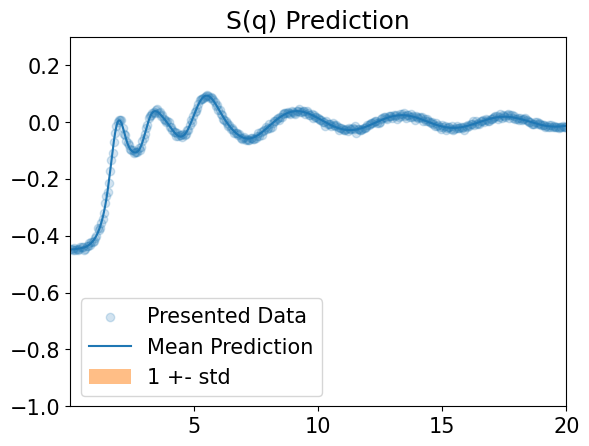

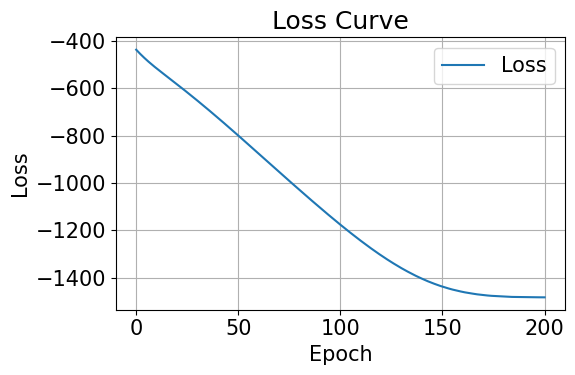

Average loss: -1482.295731  [  225/  500]
l:       0.541944 
max:     0.621539 
slope:   7.739724 
loc:     2.294257 
decay:   0.777159 
sigma_n: 0.004956 
r_0:     2.065847 
s:       9.408321 
h:   0.530357 
r:   1.523092 
s:   0.011860 
Minutes Taken Since Last Report: 1.599105 



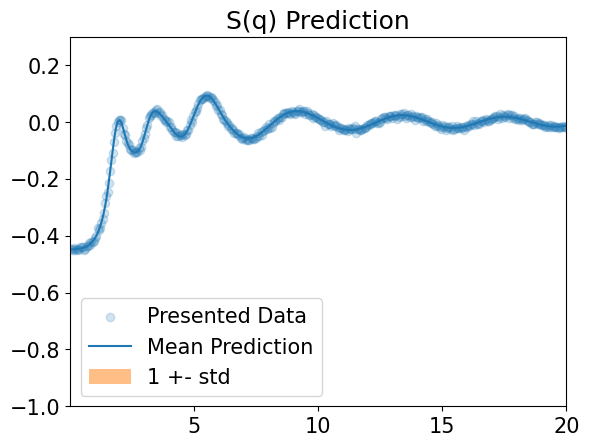

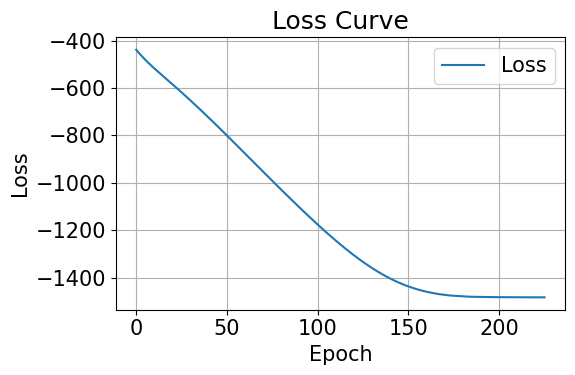

Average loss: -1482.660078  [  250/  500]
l:       0.529590 
max:     0.575046 
slope:   9.039994 
loc:     2.271394 
decay:   0.765755 
sigma_n: 0.004976 
r_0:     2.054931 
s:       9.318182 
h:   0.529749 
r:   1.523349 
s:   0.011790 
Minutes Taken Since Last Report: 1.559921 



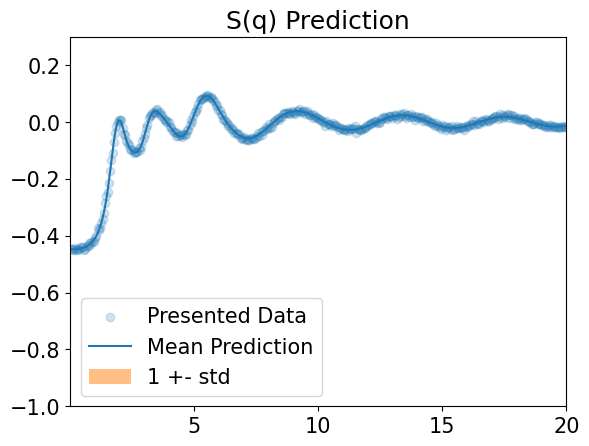

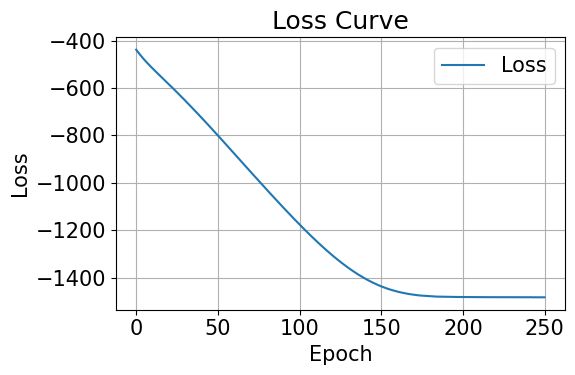

Average loss: -1483.319805  [  275/  500]
l:       0.519785 
max:     0.539365 
slope:   10.383682 
loc:     2.258699 
decay:   0.755991 
sigma_n: 0.004974 
r_0:     2.044472 
s:       9.332942 
h:   0.530248 
r:   1.523358 
s:   0.011809 
Minutes Taken Since Last Report: 1.496917 



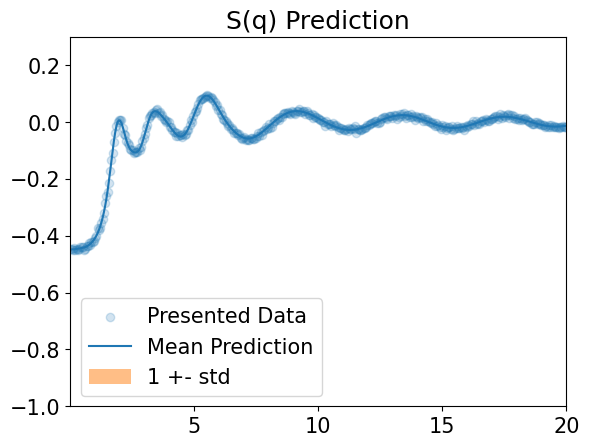

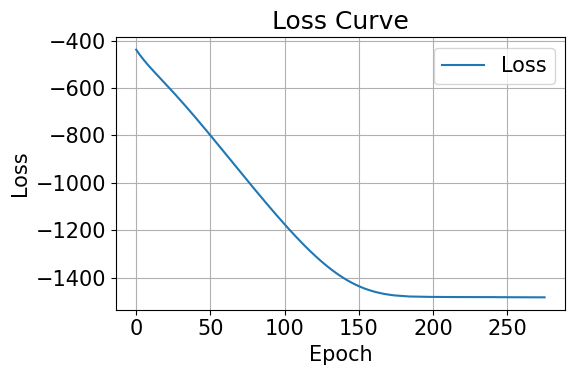

Average loss: -1483.099498  [  300/  500]
l:       0.510053 
max:     0.513252 
slope:   11.680519 
loc:     2.244453 
decay:   0.748004 
sigma_n: 0.004969 
r_0:     2.040963 
s:       9.362047 
h:   0.528577 
r:   1.524592 
s:   0.011808 
Minutes Taken Since Last Report: 1.525303 



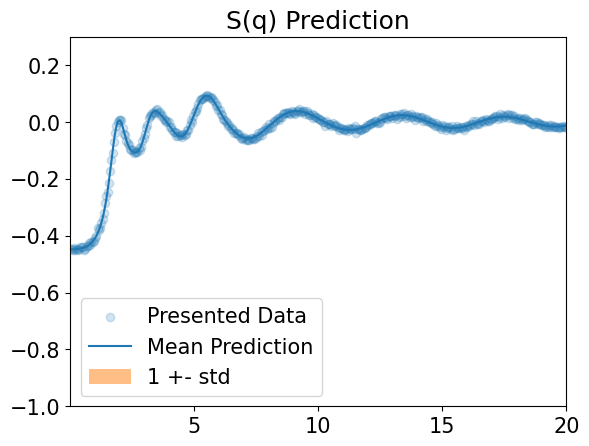

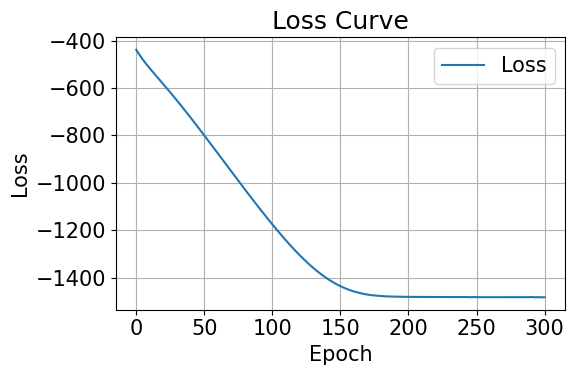

Average loss: -1483.285481  [  325/  500]
l:       0.502866 
max:     0.494844 
slope:   12.393260 
loc:     2.234848 
decay:   0.742710 
sigma_n: 0.004972 
r_0:     2.039454 
s:       9.298871 
h:   0.525473 
r:   1.523487 
s:   0.012235 
Minutes Taken Since Last Report: 1.560052 



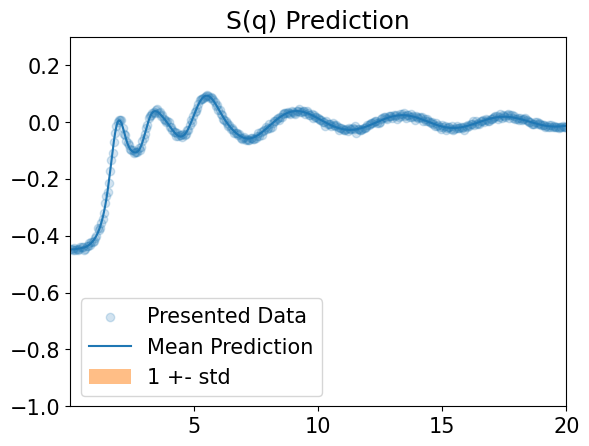

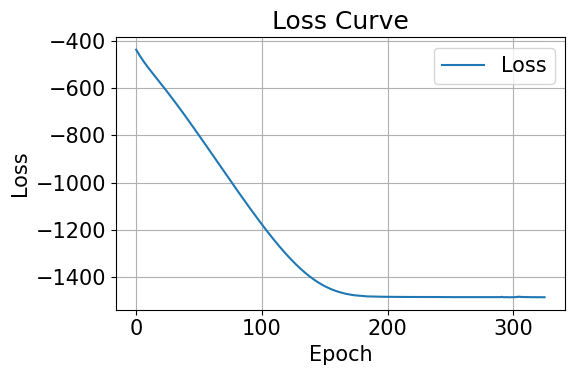

Average loss: -1483.919097  [  350/  500]
l:       0.499454 
max:     0.480286 
slope:   13.288478 
loc:     2.233279 
decay:   0.738070 
sigma_n: 0.004960 
r_0:     2.034006 
s:       9.493806 
h:   0.526208 
r:   1.523321 
s:   0.012286 
Minutes Taken Since Last Report: 1.483114 



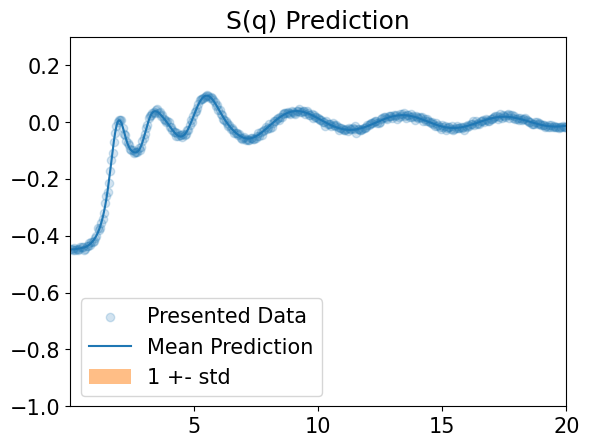

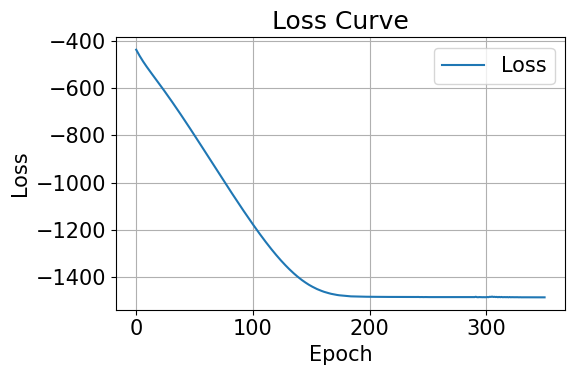

Average loss: -1484.074500  [  375/  500]
l:       0.495206 
max:     0.469039 
slope:   14.252960 
loc:     2.231834 
decay:   0.735057 
sigma_n: 0.004954 
r_0:     2.031422 
s:       9.592116 
h:   0.526763 
r:   1.523317 
s:   0.012189 
Minutes Taken Since Last Report: 1.499987 



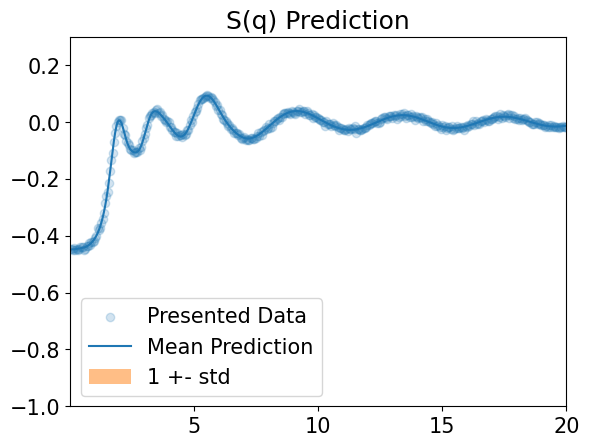

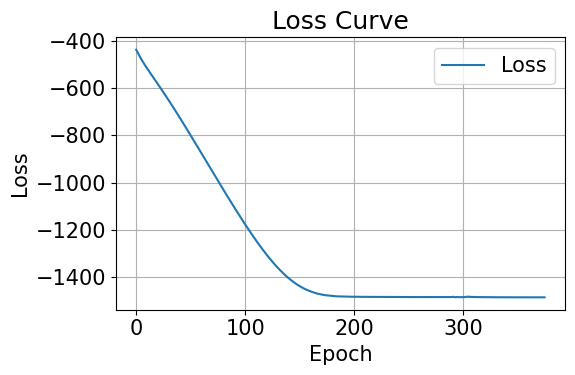

Average loss: -1484.152759  [  400/  500]
l:       0.491536 
max:     0.461201 
slope:   15.113113 
loc:     2.226896 
decay:   0.732559 
sigma_n: 0.004952 
r_0:     2.029991 
s:       9.626854 
h:   0.527552 
r:   1.523289 
s:   0.012085 
Minutes Taken Since Last Report: 1.469757 



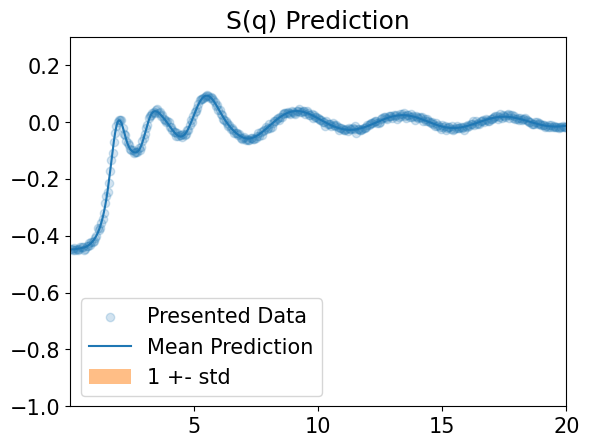

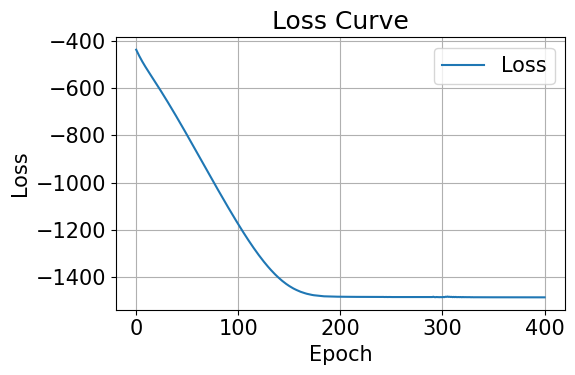

Average loss: -1484.204387  [  425/  500]
l:       0.488680 
max:     0.455471 
slope:   15.854579 
loc:     2.223793 
decay:   0.730728 
sigma_n: 0.004949 
r_0:     2.028852 
s:       9.659300 
h:   0.528350 
r:   1.523296 
s:   0.011986 
Minutes Taken Since Last Report: 1.562321 



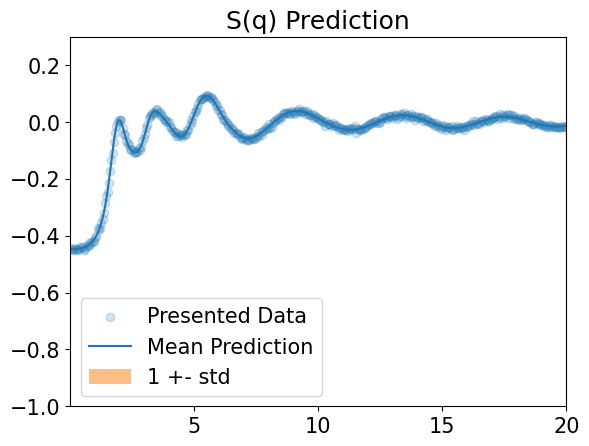

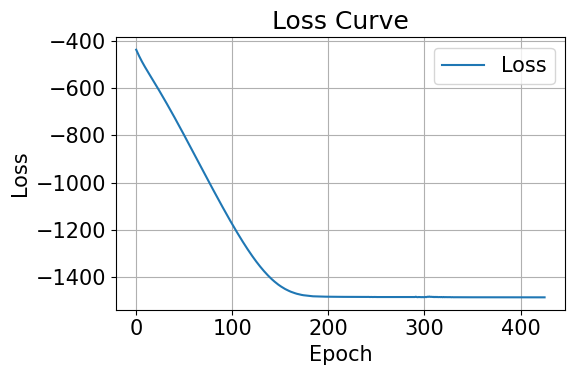

Average loss: -1484.240321  [  450/  500]
l:       0.486503 
max:     0.451301 
slope:   16.494409 
loc:     2.221235 
decay:   0.729398 
sigma_n: 0.004947 
r_0:     2.027999 
s:       9.685122 
h:   0.529162 
r:   1.523291 
s:   0.011895 
Minutes Taken Since Last Report: 1.673282 



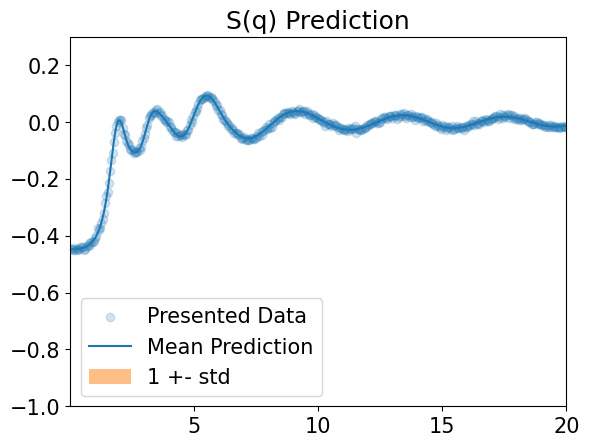

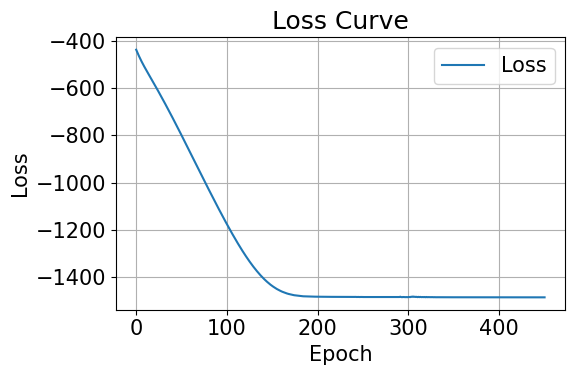

Average loss: -1484.265794  [  475/  500]
l:       0.484802 
max:     0.448289 
slope:   17.049361 
loc:     2.219126 
decay:   0.728422 
sigma_n: 0.004945 
r_0:     2.027357 
s:       9.703499 
h:   0.529964 
r:   1.523289 
s:   0.011811 
Minutes Taken Since Last Report: 1.507069 



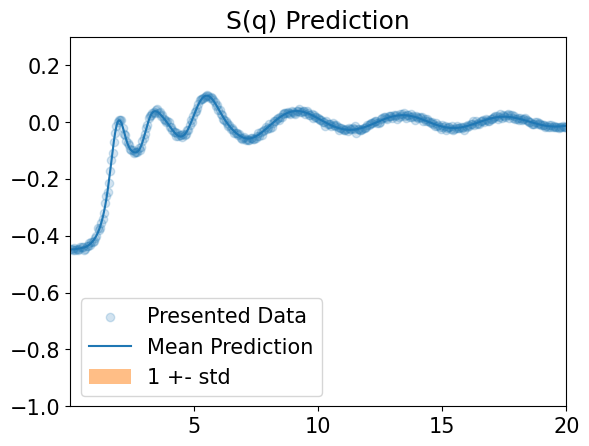

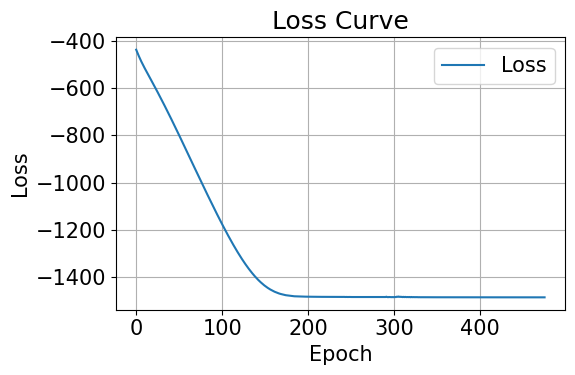

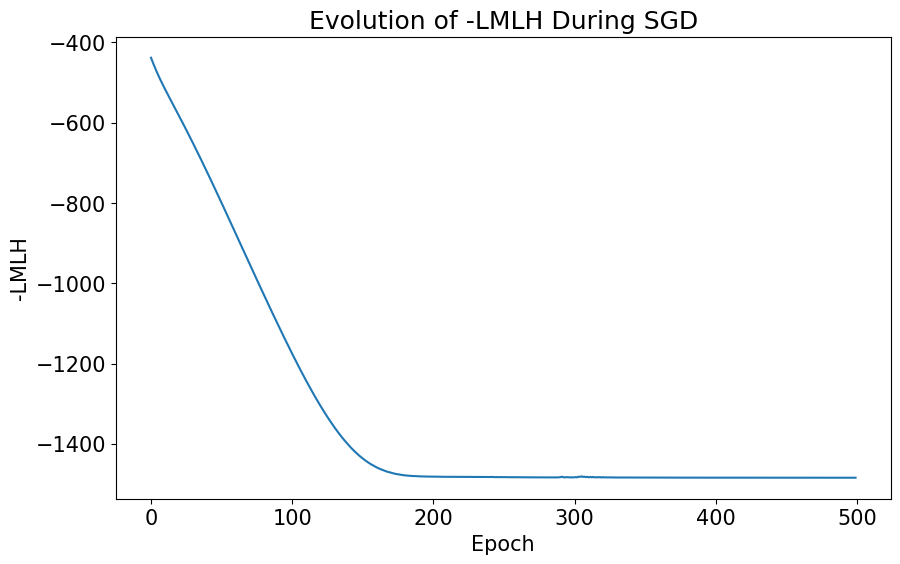

In [3]:
psq_name = 'HH'

init_param_bounds = torch.zeros((11,2))

### Width Function Params ###

# Ell
init_param_bounds[0,1] = 2.5
init_param_bounds[0,0] = 0.1


# Max
init_param_bounds[1,1] = 4
init_param_bounds[1,0] = 0.2

# Slope
init_param_bounds[2,1] = 50
init_param_bounds[2,0] = 1

# Loc
init_param_bounds[3,1] = 5
init_param_bounds[3,0] = 1.3

# Decay
init_param_bounds[4,1] = 1
init_param_bounds[4,0] = 0.05

### Experimental Noise ###

# Sigma_n
init_param_bounds[5,1] = 0.5
init_param_bounds[5,0] = 0.0001

### Non-Bonded Peaks in Mean ###

# r_0
init_param_bounds[6,1] = 6
init_param_bounds[6,0] = 1.3

# s
init_param_bounds[7,1] = 50
init_param_bounds[7,0] = 0.1

### Bonded Peaks in Mean ### 

# h_1
init_param_bounds[8,1] = 5
init_param_bounds[8,0] = 0.1

# r_1
init_param_bounds[9,1] = 2
init_param_bounds[9,0] = 0.1

# s_1
init_param_bounds[10,1] = 0.1
init_param_bounds[10,0] = 0.001


# Create initial parameters
init_params = torch.sum(init_param_bounds,dim=1)/2

init_params = torch.tensor([1.2198, 2.1105, 3.0000, 2.3000, 0.5602, 0.1059, 2.0000, 3.0000, 1.0164, 1.5211, 0.0560])


model_path = 'models/'+str(temp)+'_'+psq_name+'_GP'
loss_path = 'models/'+str(temp)+'_'+psq_name+'_losses.pt'

# Create GP Object
gp = gptransform.GP(init_params, init_param_bounds, 1, density, temp)

# Perform hyper parameter optimization
optimizer = torch.optim.AdamW(gp.parameters(), lr=2e-2)
losses = gptransform.train_loop(dataset_HH, gp, optimizer, 500, r_grid, q_values,  partial_sq_noisey_HH, q_infer, r_infer, -1,0.3, -0.1,3.1)

# Save GP
torch.save(gp, model_path)
torch.save(torch.tensor(losses), loss_path)

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(losses, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('-LMLH')
plt.title('Evolution of -LMLH During SGD')
plt.savefig('figs/'+str(temp)+'_'+psq_name+'_LMLH.png')
plt.show()

# Resulting Hyper Parameters

In [4]:
names = ["l", "max", "slope", "loc", "decay", "sigma_n", "r_0", "s", "h","r","s"]

print(f"{'Name':<10} {'Init Value':<12} {'Lower Bound':<15} {'Upper Bound':<15} {'Final Value':<15} {'Δ':<12} {'% Change':<10}")
print("-" * 100)

for name, init, lo, hi, final in zip(
    names,
    init_params.tolist(),
    init_param_bounds.T[0].tolist(),
    init_param_bounds.T[1].tolist(),
    gp.theta.tolist()
):
    delta = final - init
    denom = hi - lo
    percent = 100 * delta / denom 
    print(f"{name:<10} {init:<12.6f} {lo:<15.6f} {hi:<15.6f} {final:<15.6f} {delta:<12.6f} {percent:<10.2f}")


Name       Init Value   Lower Bound     Upper Bound     Final Value     Δ            % Change  
----------------------------------------------------------------------------------------------------
l          1.219800     0.100000        2.500000        0.395234        -0.824566    -34.36    
max        2.110500     0.200000        4.000000        0.375821        -1.734679    -45.65    
slope      3.000000     1.000000        50.000000       17.704970       14.704970    30.01     
loc        2.300000     1.300000        5.000000        2.285289        -0.014711    -0.40     
decay      0.560200     0.050000        1.000000        0.725091        0.164891     17.36     
sigma_n    0.105900     0.000100        0.500000        0.005096        -0.100804    -20.16    
r_0        2.000000     1.300000        6.000000        2.008273        0.008273     0.18      
s          3.000000     0.100000        50.000000       13.952920       10.952920    21.95     
h          1.016400     0.100000   

# Apply Laplaces Approximation

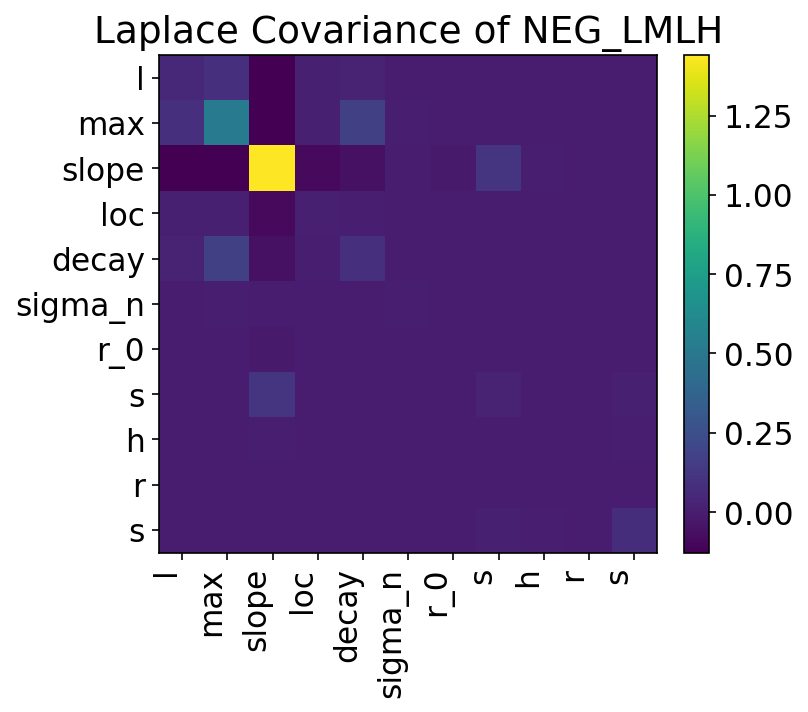

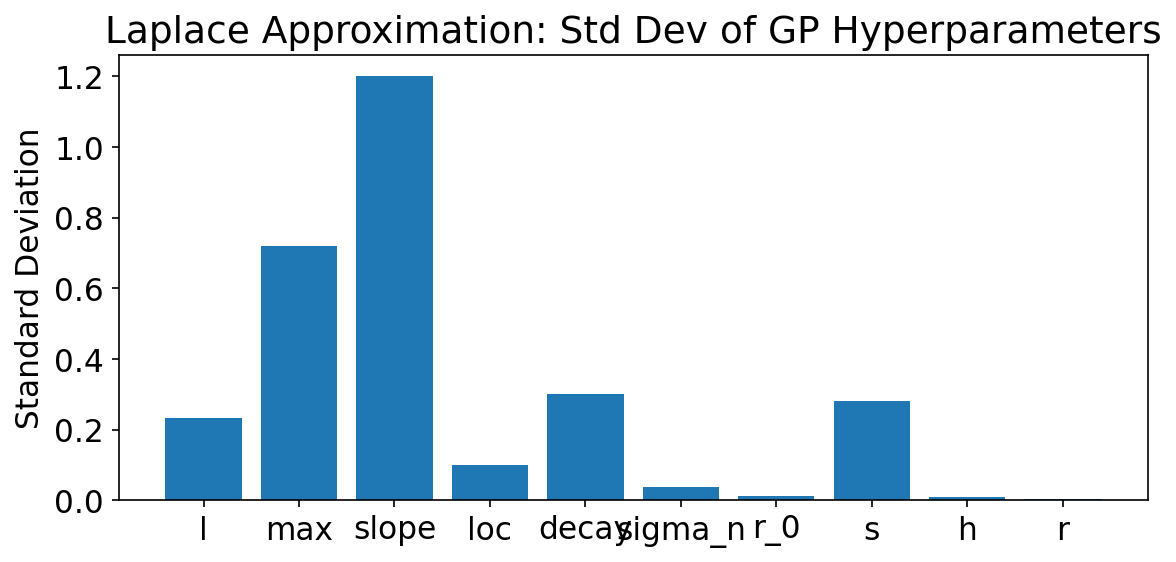

In [5]:
q_train = q_values
sq_train = partial_sq_noisey_HH

loss_at_map = gp.NEG_LMLH_Trapz(r_grid, q_values, sq_train)

grad = torch.autograd.grad(loss_at_map, gp.theta_raw, create_graph=True)[0]  # shape: (P,)
P = grad.numel()
grad_flat = grad.view(-1)

H = torch.zeros(P, P, device=grad.device)
for i in range(P):
    grad2 = torch.autograd.grad(grad_flat[i], gp.theta_raw, retain_graph=True)[0].view(-1)
    H[i] = grad2.detach()

L = torch.linalg.cholesky(gp.nearestPD(H))  
cov_laplace = torch.cholesky_inverse(L)

stds = torch.sqrt(torch.diag(cov_laplace)).cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
im = ax.imshow(cov_laplace, cmap='viridis')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(range(P))
ax.set_yticks(range(P))
ax.set_xticklabels(names, rotation=90, ha='right')
ax.set_yticklabels(names)
ax.set_title("Laplace Covariance of NEG_LMLH")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
ax.bar(names, stds)
ax.set_ylabel("Standard Deviation")
ax.set_title("Laplace Approximation: Std Dev of GP Hyperparameters")
plt.tight_layout()
plt.show()

#  Compute the Posteriors

In [6]:
with torch.no_grad():

    r_grid =  torch.linspace(0.01, 25  , 1000).reshape(-1,1)
    r_infer = torch.linspace(0.01, 12.5, 1000).reshape(-1,1)
    q_infer = torch.linspace(0.01, 12.5, 1000).reshape(-1,1)

    # Calculate Posterior Mean and Cov in momentum space
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()
    
    μ_q_prior = gp.mean_q(r_grid,q_infer)
    Σ_q_prior = gp.K_qq(r_grid, r_grid, q_infer, q_infer,adjust=False)

    # Calculate Posterior Mean and Cov in real space
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r_infer, q_train, sq_train,adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()
    
    μ_r_prior = gp.mean_r(r_infer)
    Σ_r_prior = gp.K_rr(r_infer, r_infer,adjust=False)

    kernels = [(Σ_q_post, q_infer.T[0], q_infer.T[0]),(Σ_r_post, r_infer.T[0], r_infer.T[0])]   

# Plot the Posteriors

/var/folders/tv/1d811xv917v4wz50x1bqpvcc0000gn/T/ipykernel_45345/3580191949.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


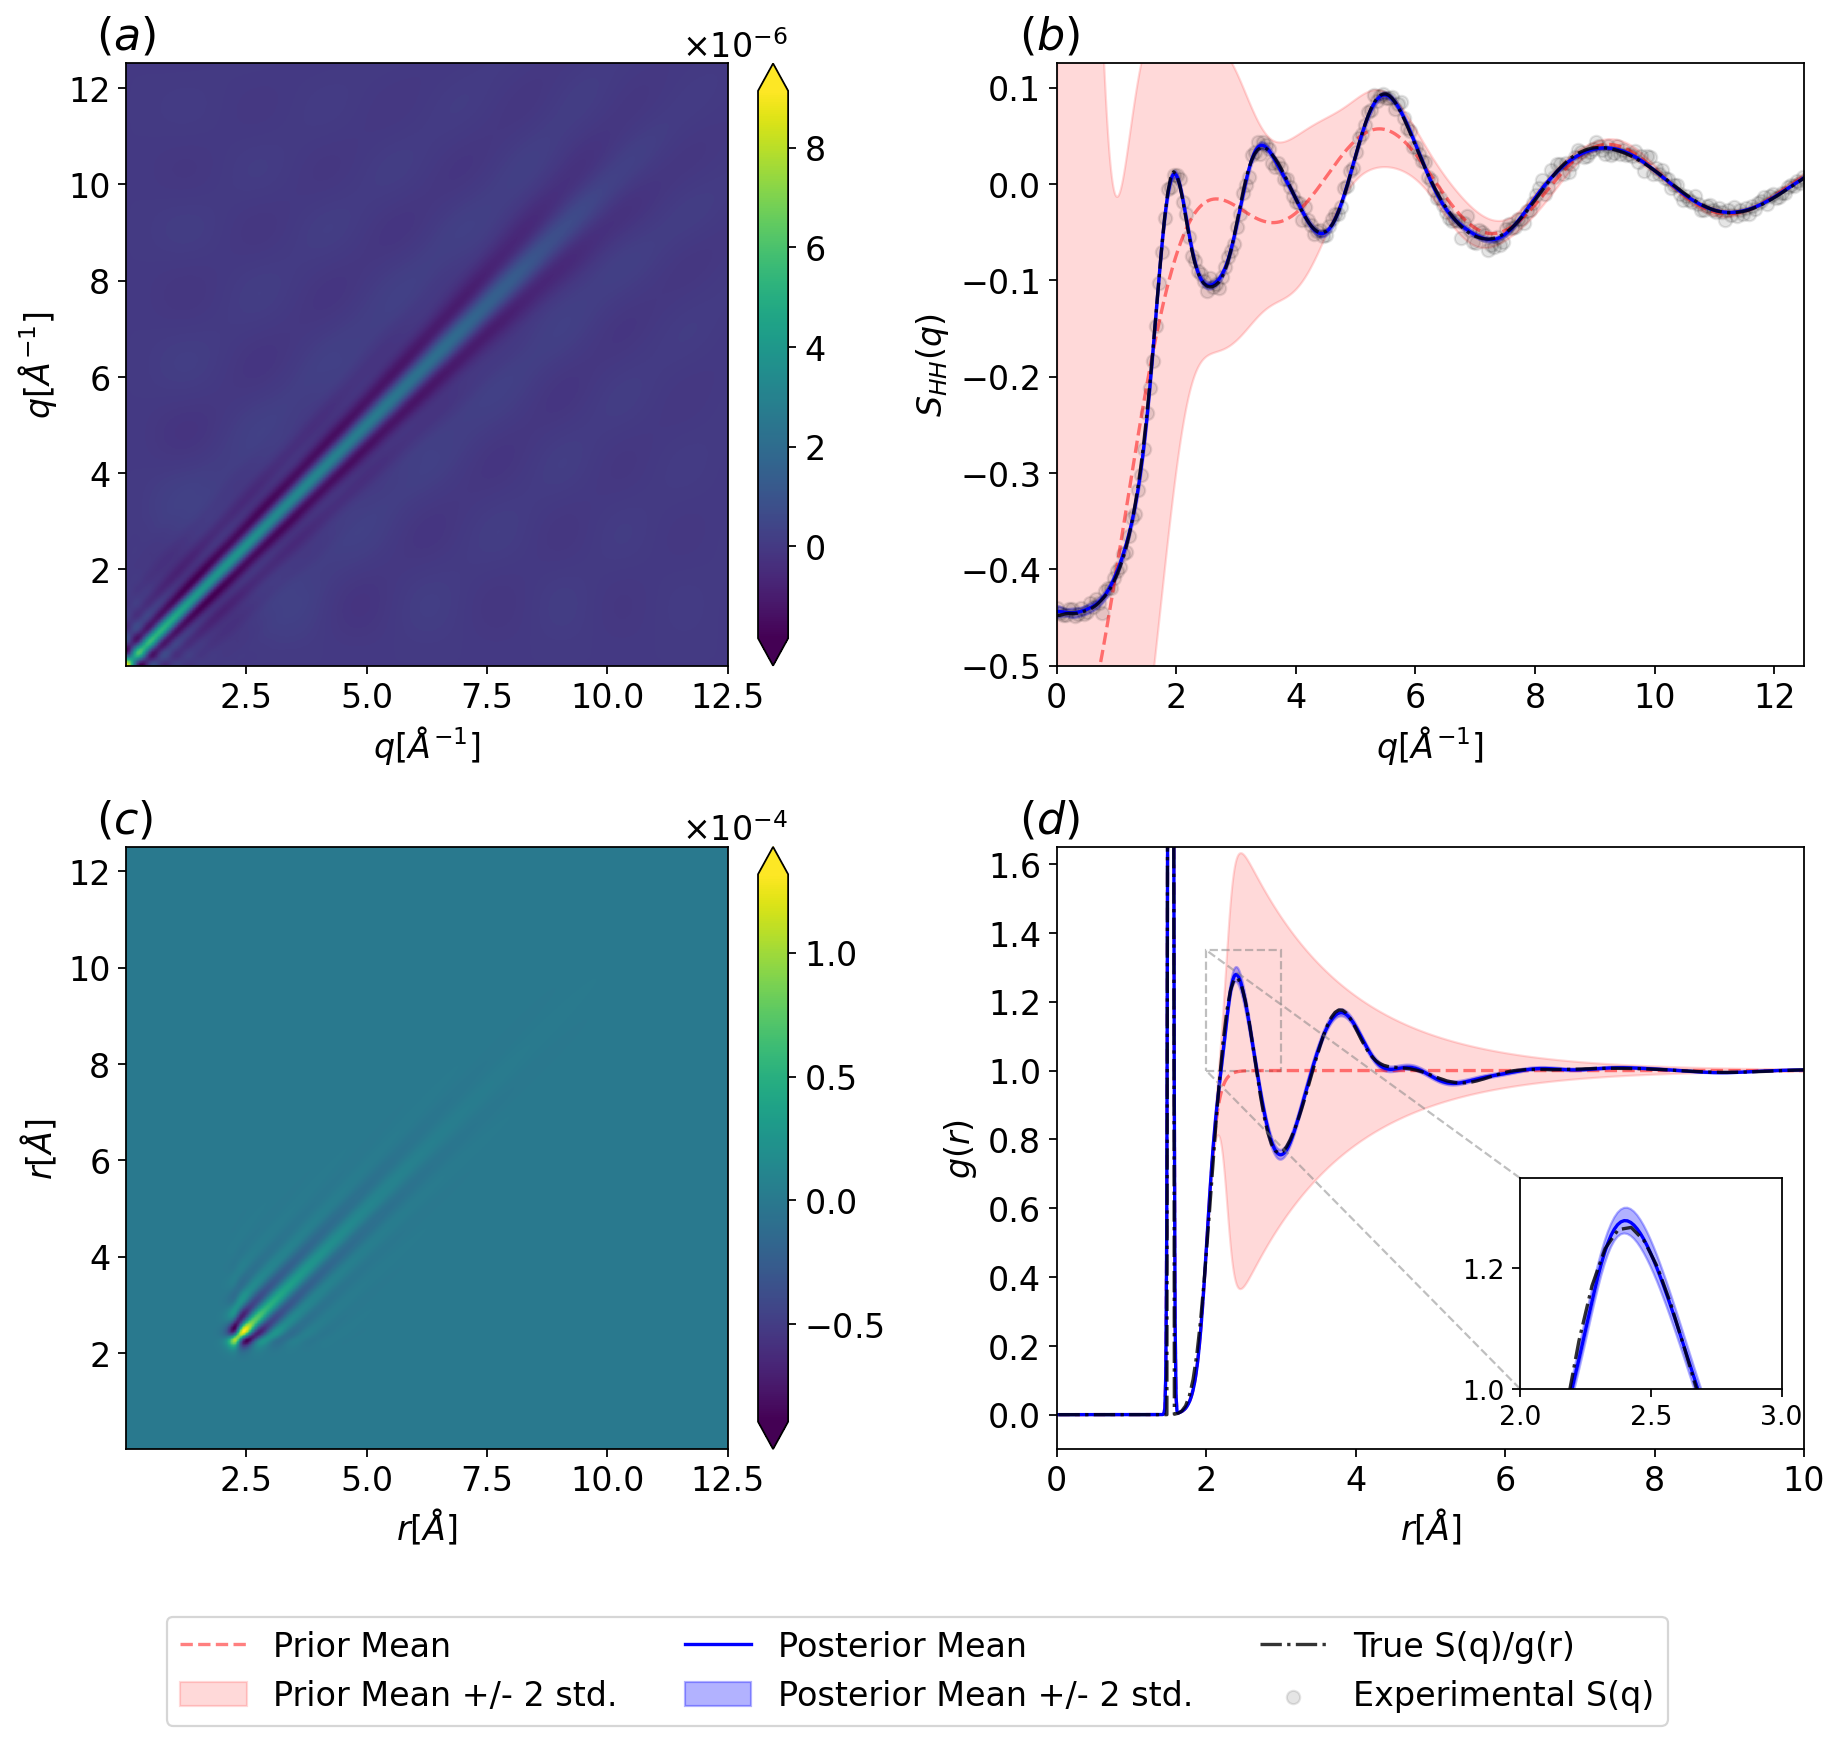

In [15]:
titles = ["$\Sigma_{{Post.}}$", "$\Sigma_{{Post.,RDF}}$",]
xlabels = ["$q [\AA^{-1}]$", "$r [\AA]$"]
ylabels = ["$q [\AA^{-1}]$", "$r [\AA]$"]

fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=160)

bound = 30

for idx, (ax, (kernel, x_dom, y_dom), title, xlabel, ylabel) in enumerate(
        zip(axs[:,0], kernels, titles, xlabels, ylabels)):

    kernel = kernel.clamp(-bound, bound)         
    vmin, vmax = -bound, bound
    extend_opt = 'both'                     

    c = ax.pcolormesh(x_dom.numpy(), y_dom.numpy(),
                      kernel.numpy(), shading='auto',
                      cmap='viridis')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal')

    cb = fig.colorbar(c, ax=ax, fraction=0.046, pad=0.04,
                 extend=extend_opt, extendfrac=0.05)
    
    cb.formatter = ScalarFormatter(useMathText=True)
    cb.formatter.set_scientific(True)
    cb.formatter.set_powerlimits((-2, 2))
    cb.update_ticks()
    
fill_between_alpha = 0.3
prior_fill_between_ratio = 0.5
lettering_size = 20

axs[0,1].plot(q_infer.T[0], μ_q_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
axs[0,1].fill_between(q_infer.T[0], μ_q_prior.T[0] + 2*torch.diag(Σ_q_prior)**0.5, μ_q_prior.T[0] - 2*torch.diag(Σ_q_prior)**0.5, alpha=prior_fill_between_ratio*fill_between_alpha, label="Prior Mean +/- 2 std.", color='r')
axs[0,1].plot(q_infer.T[0], μ_q_post.T[0], label="Posterior Mean", color='b')
axs[0,1].fill_between(q_infer.T[0], μ_q_post.T[0] + 2*torch.diag(Σ_q_post)**0.5, μ_q_post.T[0] - 2*torch.diag(Σ_q_post)**0.5, alpha=fill_between_alpha, label="Posterior Mean +/- 2 std.", color='b')
axs[0,1].plot(q_values,partial_sq_HH, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
axs[0,1].scatter(q_train, sq_train, label='Experimental S(q)', alpha=0.1, color='k')
axs[0,1].set_xlim(0, 12.5)
axs[0,1].set_ylim(-0.5,0.125)
axs[0,1].set_xlabel('$q [Å^{-1}]$')
axs[0,1].set_ylabel('$S_{HH}(q)$')

axs[1,1].plot(r_infer.T[0], μ_r_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
axs[1,1].fill_between(r_infer.T[0], μ_r_prior.T[0] + 2*torch.diag(Σ_r_prior)**0.5, μ_r_prior.T[0] - 2*torch.diag(Σ_r_prior)**0.5, alpha=prior_fill_between_ratio*fill_between_alpha, label="Prior Mean +/- 2 std.", color='r')
axs[1,1].plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
axs[1,1].fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=fill_between_alpha, label="Posterior Mean +/- 2 std.", color='b')
axs[1,1].plot(r,gr_HH, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
# axs[1,1].plot(r_infer.T[0], gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r_infer.T[0], density)+1, label='$\mathcal{H}$ of Experimental S(q)', color='darkgreen',alpha=0.8,linestyle='dashdot')
axs[1,1].set_ylim(-0.1, 1.65)
axs[1,1].set_xlim(0, 10)
axs[1,1].set_xlabel('$r [Å]$')
axs[1,1].set_ylabel('$g(r)$')
     
axins = inset_axes(
    axs[1, 1],
    width="35%", height="35%",
    bbox_to_anchor=(0.62, 0.1, 1, 1),
    bbox_transform=axs[1,1].transAxes,
    loc='lower left',
    borderpad=0
)

axins.plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
axins.fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=fill_between_alpha, label="Posterior Mean +/- 2 std.", color='b')
axins.plot(r,gr_HH, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
# axins.plot(r_infer.T[0], gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r_infer.T[0], density)+1, label='$\mathcal{H}$ of Experimental S(q)', color='darkgreen',alpha=0.8,linestyle='dashdot')
axins.set_ylim(1, 1.35)
axins.set_xlim(2,3)


axins.tick_params(labelsize=12)

mark_inset(axs[1,1], axins, loc1=2, loc2=3, fc="none", ec="0.5",linestyle='dashed',alpha=0.5)


# axins = inset_axes(axs[1,1],
#                    width="35%", height="35%",      
#                    loc='upper right',              
#                    borderpad=1.2)                  

# axins.plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
# axins.fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=fill_between_alpha, label="Posterior Mean +/- 2 std.", color='b')
# axins.plot(r,gr_HH, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
# # axins.plot(r_infer.T[0], gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r_infer.T[0], density)+1, label='$\mathcal{H}$ of Experimental S(q)', color='darkgreen',alpha=0.8,linestyle='dashdot')
# axins.set_xlim(1.45, 1.6)
# axins.set_ylim(-0.1,11)

# axins.tick_params(labelsize=12)
# mark_inset(axs[1,1], axins, loc1=2, loc2=3, fc="none", ec="0.5",linestyle='dashed',alpha=0.5)

# Collect unique legend handles and labels
handles1, labels1 = axs[0,1].get_legend_handles_labels()
handles2, labels2 = axs[1,1].get_legend_handles_labels()

# Use dict to ensure uniqueness
handle_label_dict = dict(zip(labels1 + labels2, handles1 + handles2))
labels_combined, handles_combined = zip(*handle_label_dict.items())

# Add figure-level legend below all subplots
fig.legend(
    handles_combined, labels_combined,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=True
)

for i, ax in enumerate(axs.flat):
    label = f"$({string.ascii_lowercase[i]})$"
    ax.text(-0.05, 1.08, label,
            transform=ax.transAxes,
            fontsize=lettering_size, va='top', ha='left')


plt.tight_layout()
plt.savefig("figs/HH_Simulated_post.png", bbox_inches='tight')

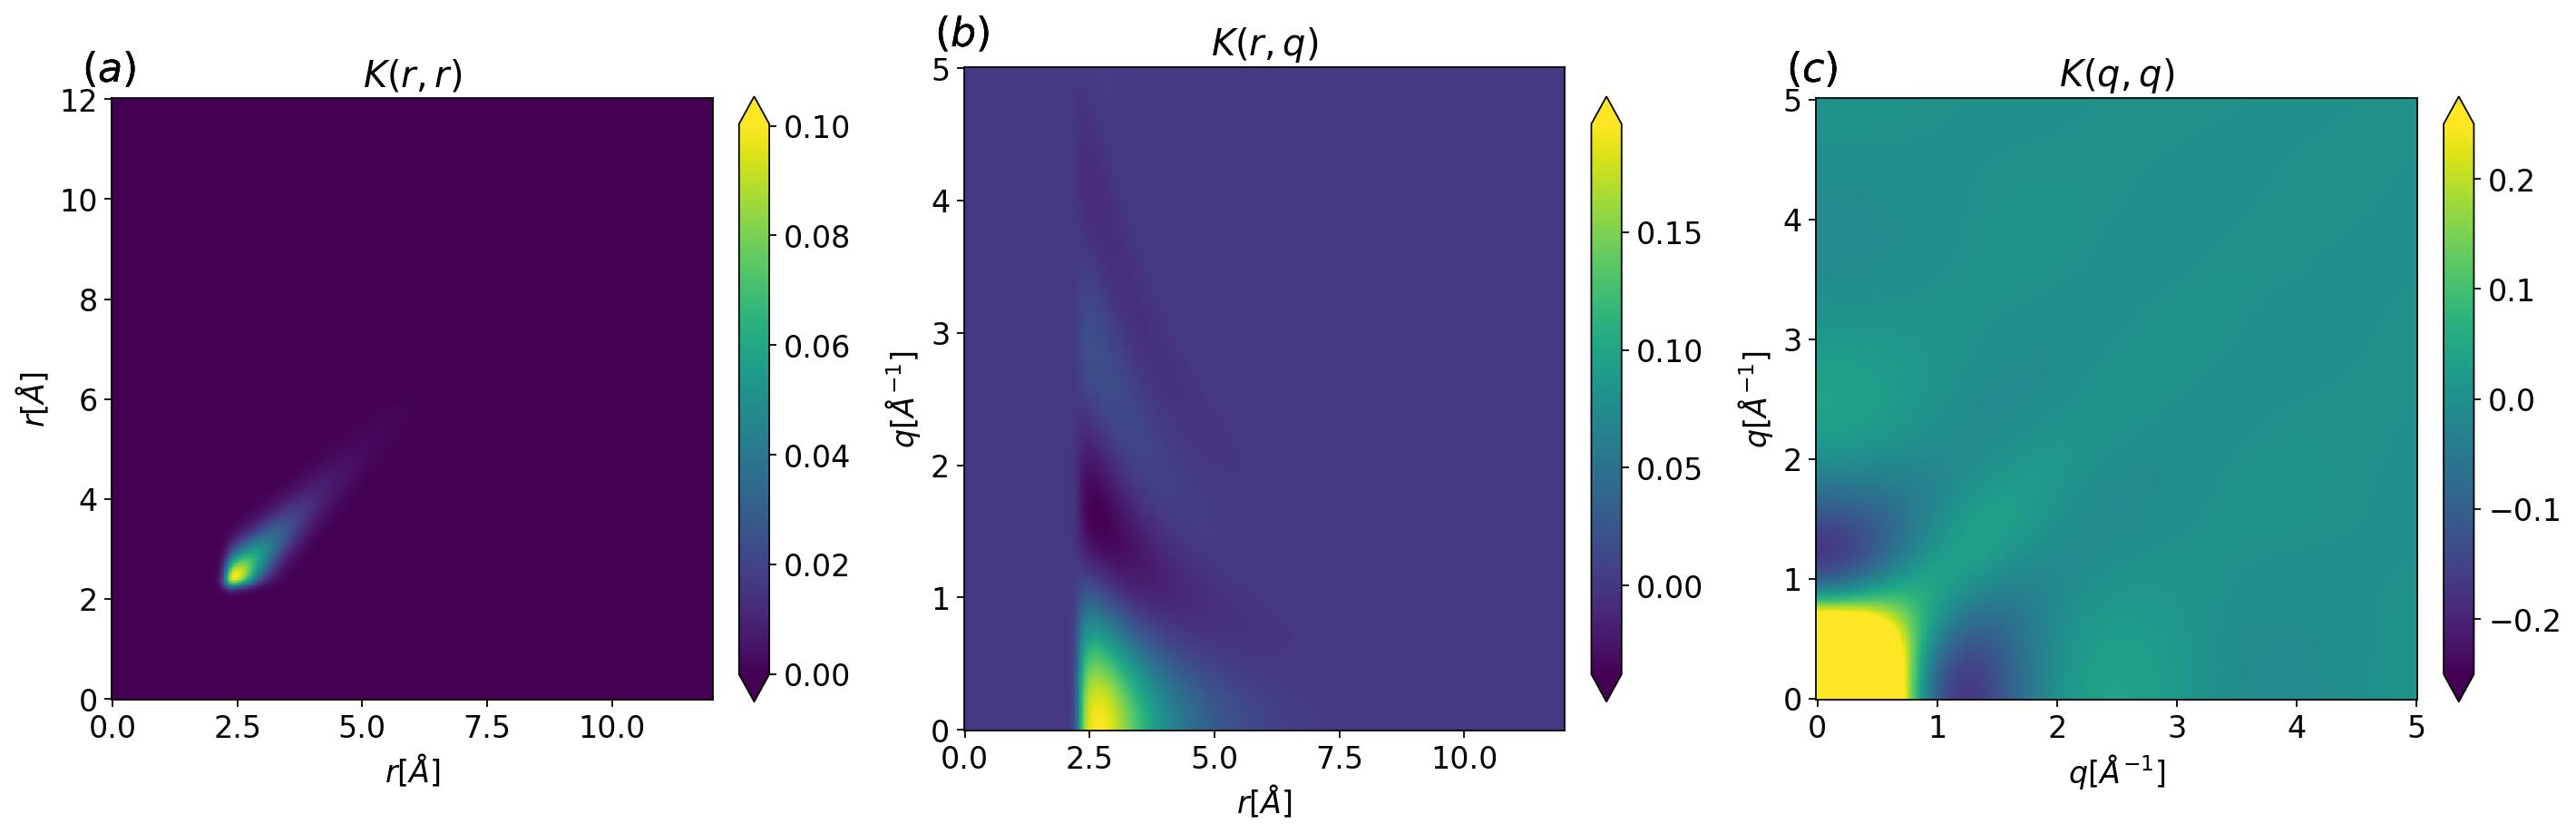

In [23]:
with torch.no_grad():
    r_infer_k_plot = torch.linspace(0.0001, 12, 400).reshape(-1,1)
    q_infer_k_plot = torch.linspace(0.0001, 5, 300).reshape(-1,1)
    
    bound = 0.25

    # Calculate kernel matrices for each domain
    K1_matrix = gp.K_rr(r_infer_k_plot,r_infer_k_plot,adjust=False).detach()
    K2_matrix = gp.K_rq(r_infer_k_plot,r_grid,q_infer_k_plot,adjust=False).T.detach()
    K3_matrix = gp.K_qq(r_grid,r_grid,q_infer_k_plot,q_infer_k_plot,adjust=False).detach()

    # Set up the figure
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=160)
    kernels = [(K1_matrix, r_infer_k_plot.T[0], r_infer_k_plot.T[0]), (K2_matrix, r_infer_k_plot.T[0], q_infer_k_plot.T[0]), (K3_matrix, q_infer_k_plot.T[0], q_infer_k_plot.T[0])]
    titles = ["$K(r,r)$", "$K(r,q)$", "$K(q,q)$"]
    xlabels = ["$r [\AA]$", "$r [\AA]$", "$q [\AA^{-1}]$"]
    ylabels = ["$r [\AA]$", "$q [\AA^{-1}]$", "$q [\AA^{-1}]$"]
    i = 0
    for idx, (ax, (kernel, x_dom, y_dom), title, xlabel, ylabel) in enumerate(
            zip(axs, kernels, titles, xlabels, ylabels)):

        if idx == 2:                                   # clamp & fixed range
            kernel = kernel.clamp(-bound, bound)
            c = ax.pcolormesh(x_dom.numpy(), y_dom.numpy(), kernel.numpy(),
                              shading='auto', cmap='viridis',
                              vmin=-bound, vmax=bound)
        else:
            c = ax.pcolormesh(x_dom.numpy(), y_dom.numpy(), kernel.numpy(),
                              shading='auto', cmap='viridis')

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if idx != 1:
            ax.set_aspect('equal')

        fig.colorbar(c, ax=ax, fraction=0.046, pad=0.04,
                     extend='both', extendfrac=0.05)
        
        for i, ax in enumerate(axs.flat):
            label = f"$({string.ascii_lowercase[i]})$"
            ax.text(-0.05, 1.08, label,
                    transform=ax.transAxes,
                    fontsize=lettering_size, va='top', ha='left')

    plt.tight_layout()
    plt.savefig("figs/HH_Simulated_kernels.png")

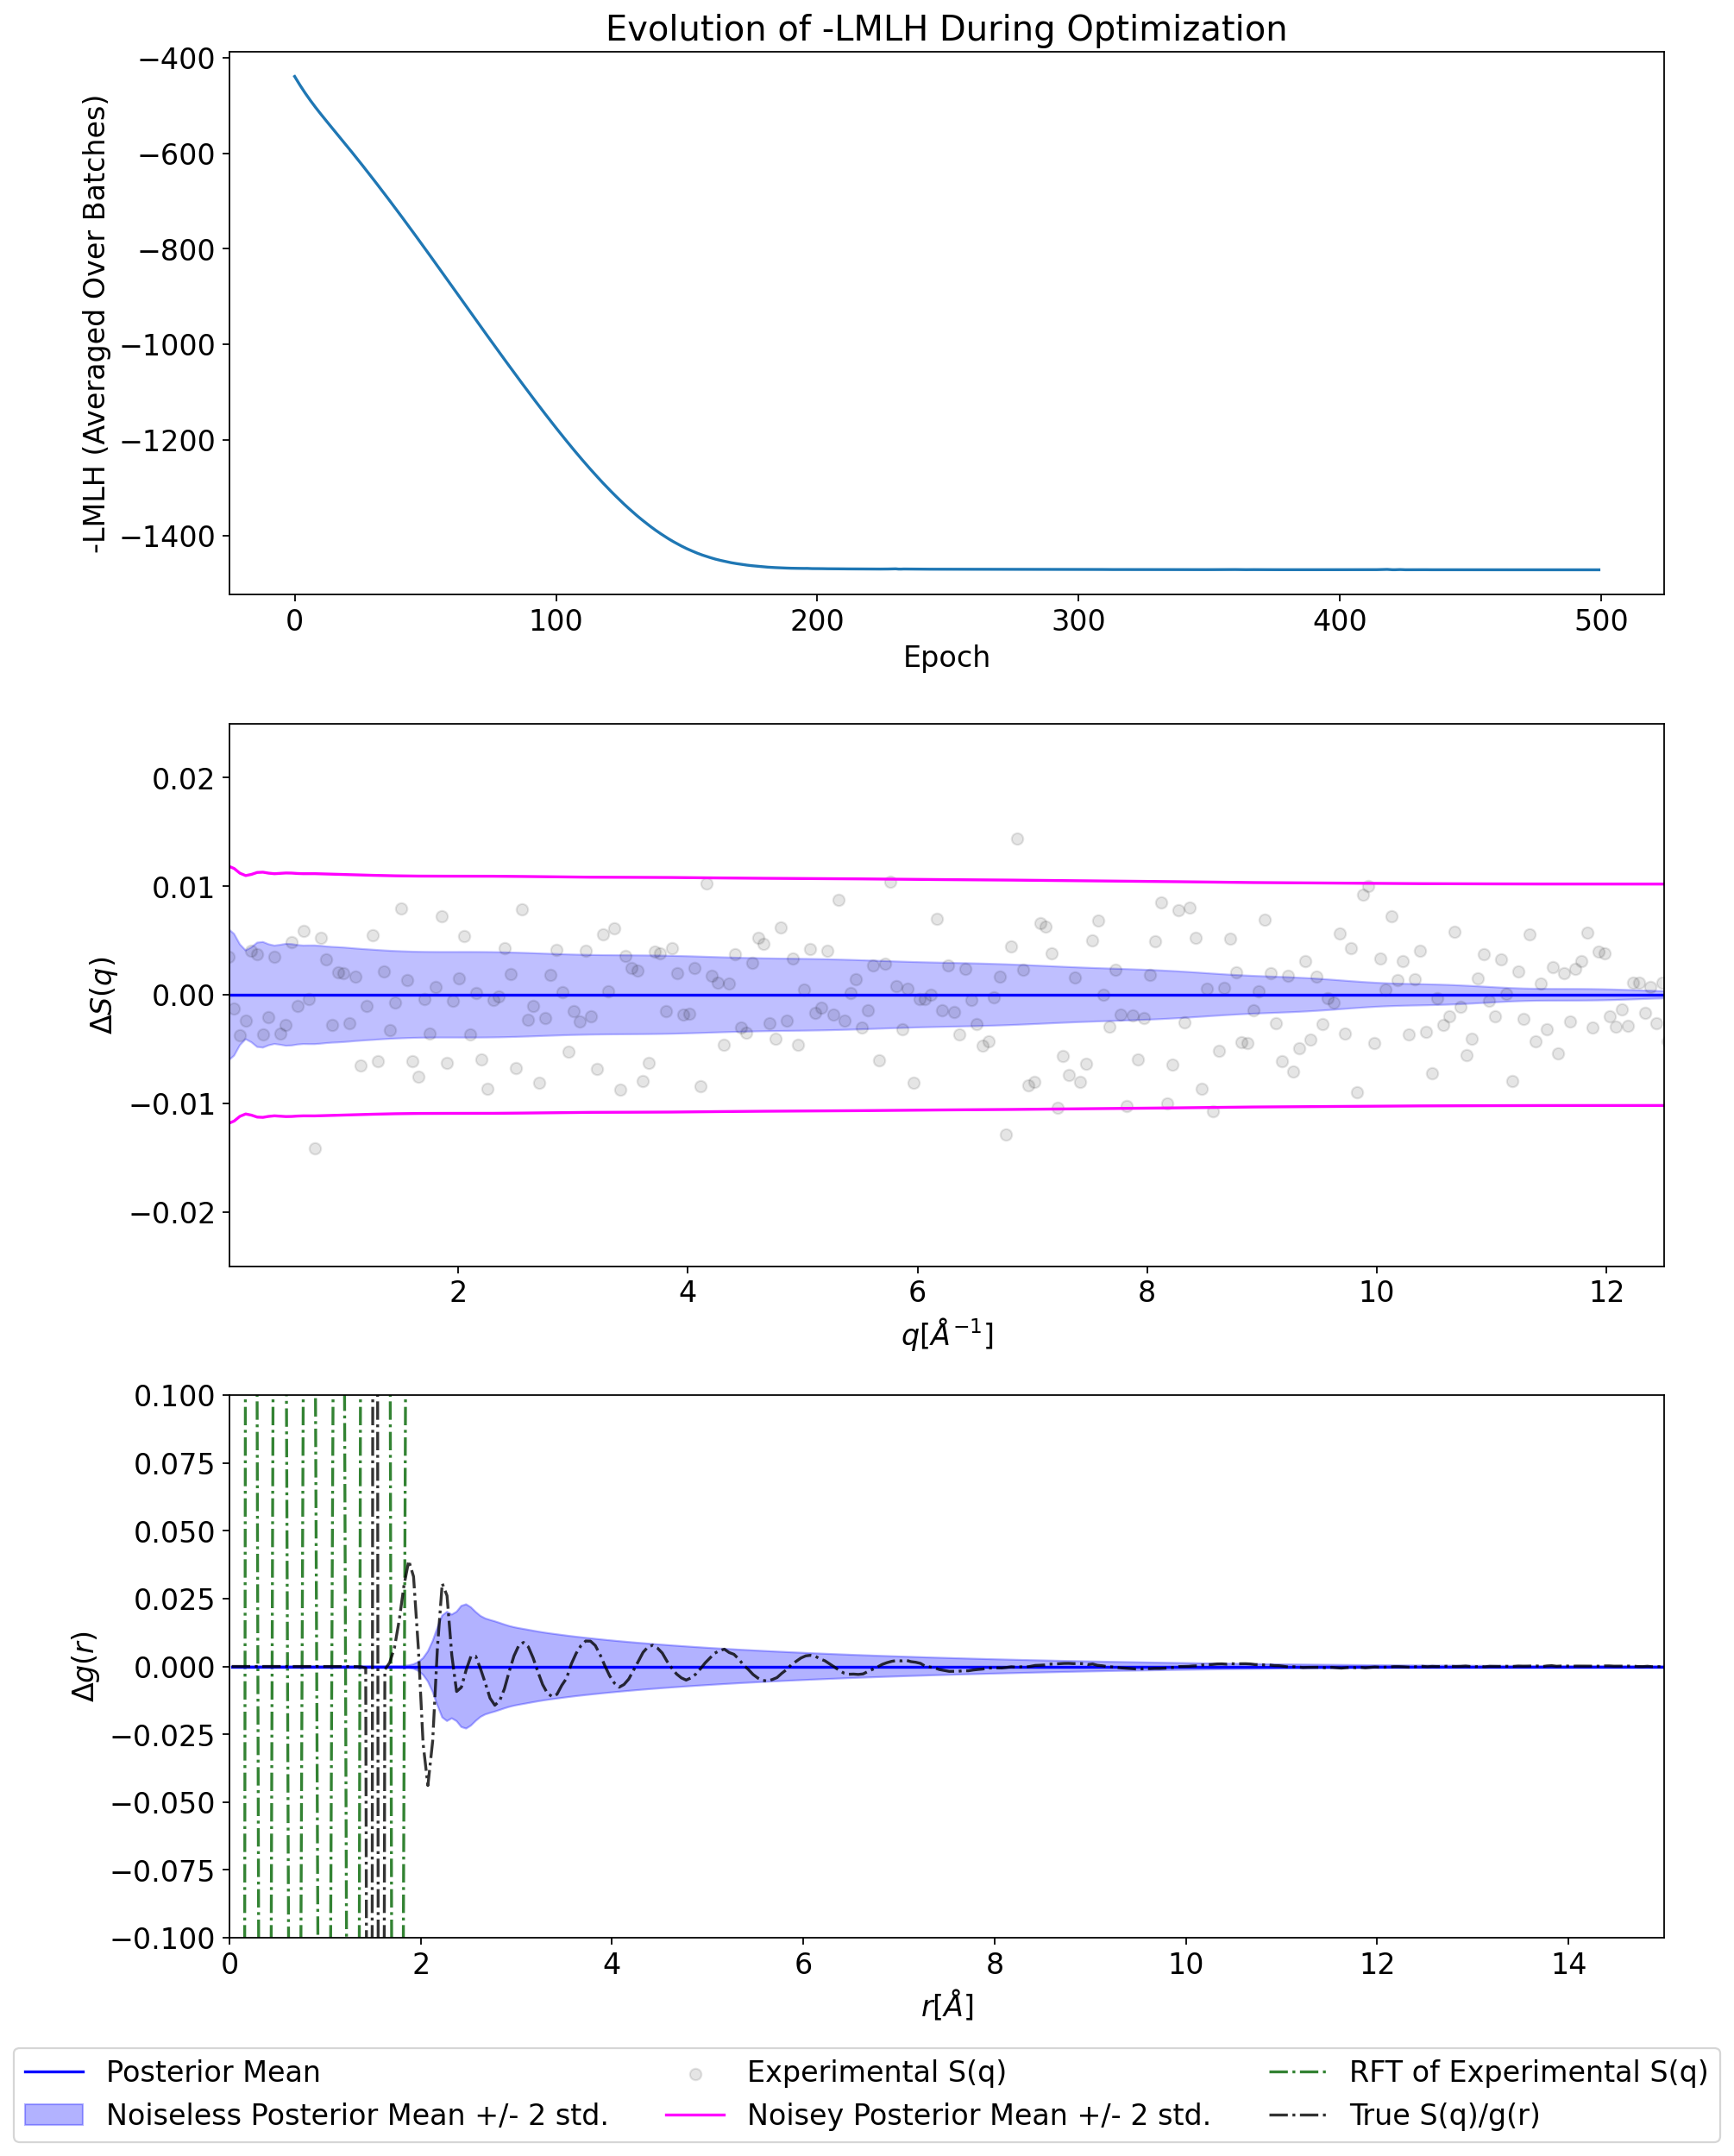

In [24]:
with torch.no_grad():
    fig, axs = plt.subplots(3,1, figsize=(12, 15), dpi=160)
    
    q_infer = q_train
        
    # Calculate Prior Mean and Cov
    Σ_q_prior = gp.K_qq(r_grid,r_grid,q_infer,q_infer).detach()
    μ_q_prior = gp.mean_q(r_grid,q_infer).detach()
    
    Σ_r_prior = gp.K_rr(r.reshape(-1,1),r.reshape(-1,1)).detach()
    μ_r_prior = gp.mean_r(r.reshape(-1,1)).detach()

    # Calculate Posterior Mean and Cov
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()
    
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r.reshape(-1,1), q_train, sq_train,adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()    
        
    axs[1].plot(q_infer.T[0],torch.zeros_like(q_infer.T[0]),label="Posterior Mean",color='b')
    axs[1].fill_between(q_infer.T[0],2*torch.diag(Σ_q_post)**0.5,  -2*torch.diag(Σ_q_post)**0.5,alpha=0.25,label="Noiseless Posterior Mean +/- 2 std.",color='b')
    axs[1].scatter(q_train,sq_train-μ_q_post,label='Experimental S(q)',alpha=0.1,color='k')
    axs[1].plot(q_infer.T[0],2*torch.diag(Σ_q_post + torch.eye(len(q_infer))*(gp.theta[5]**2))**0.5,label="Noisey Posterior Mean +/- 2 std.",color='magenta')
    axs[1].plot(q_infer.T[0],-2*torch.diag(Σ_q_post + torch.eye(len(q_infer))*(gp.theta[5]**2))**0.5,color='magenta')

    axs[1].set_xlim(0.01,12.5)
    axs[1].set_ylim(-0.025,0.025)

    axs[1].set_xlabel('$q [Å^{-1}]$')
    axs[1].set_ylabel('$\Delta S(q)$')
    
    # axs[2].plot(r, μ_r_prior.T[0] - μ_r_post.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    # axs[2].fill_between(r, μ_r_prior.T[0]- μ_r_post.T[0] + 2*torch.diag(Σ_r_prior)**0.5, μ_r_prior.T[0]- μ_r_post.T[0] - 2*torch.diag(Σ_r_prior)**0.5, alpha=prior_fill_between_ratio*fill_between_alpha, label="Prior Mean +/- 2 std.", color='r')
    axs[2].plot(r, gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r, density)+1 - μ_r_post[0], label='RFT of Experimental S(q)', color='darkgreen',alpha=0.8,linestyle='dashdot')
    axs[2].plot(r, μ_r_post.T[0]- μ_r_post.T[0], label="Posterior Mean", color='b')
    axs[2].fill_between(r, μ_r_post.T[0]- μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0]- μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=fill_between_alpha, label="Noiseless Posterior Mean +/- 2 std.", color='b')
    axs[2].plot(r,gr_HH - μ_r_post.T[0] , label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
    
    axs[2].set_ylim(-0.1,0.1)
    axs[2].set_xlim(0,15)
    axs[2].set_xlabel('$r [Å]$')
    axs[2].set_ylabel('$\Delta g(r)$')


    axs[0].plot(torch.tensor(losses), linestyle='-')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('-LMLH (Averaged Over Batches)')
    axs[0].set_title('Evolution of -LMLH During Optimization')
    
    # Collect unique legend handles and labels
    handles1, labels1 = axs[1].get_legend_handles_labels()
    handles2, labels2 = axs[2].get_legend_handles_labels()

    # Use dict to ensure uniqueness
    handle_label_dict = dict(zip(labels1 + labels2, handles1 + handles2))
    labels_combined, handles_combined = zip(*handle_label_dict.items())

    # Add figure-level legend below all subplots
    fig.legend(
        handles_combined, labels_combined,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=3,
        frameon=True
    )

plt.tight_layout()
plt.savefig("figs/HH_simulated_si.png", bbox_inches='tight')